In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error
from src.utils import *
from src.MetricLinearRegression import MetricLinearRegression
import matplotlib.pyplot as plt

In [13]:
def neg_mean_error(estimator, X, y_true):
    y_true = discretize_metric(y_true[:, 0], estimator.pos_threshold, estimator.neg_threshold)
    y_pred = estimator.predict(X)
    print(y_true)
    print(y_pred)
    return -mean_absolute_error(y_true, y_pred)

In [15]:
def grid_search(X, y):
    lin_reg = MetricLinearRegression()
    grid_reg = np.linspace(0, 10, num=50)
    grid_beta = np.linspace(0, 10, num=5)
    params = {'l2_reg': grid_reg, 'beta': grid_beta}
    gs = GridSearchCV(lin_reg, param_grid=params, scoring=neg_mean_error, iid=False, cv=5, verbose=1, n_jobs=-1)
    gs.fit(X, y)
    print(gs.best_score_)
    print(gs.best_params_)
    return gs.cv_results_

In [4]:
def evaluate_model(X, y, l2_reg, beta, pos_threshold, neg_threshold):
    lin_reg = MetricLinearRegression(l2_reg, beta, pos_threshold=pos_threshold, neg_threshold=neg_threshold)
    scores = cross_validate(lin_reg, X, y, scoring=neg_mean_error, cv=5, n_jobs=-1)
    print(np.mean(scores['test_score']))

In [6]:
dataset_path = '../dataset/feed_top_ab_tests_pool_dataset.csv'

df = pd.read_csv(dataset_path)
data = df.to_numpy()
LONG_TERM_COUNT = 4
y = data[:, :LONG_TERM_COUNT * 2]
X = data[:, LONG_TERM_COUNT * 2:-1]
zipped_X = zip_with_p_value(X)
zipped_y = zip_with_p_value(y)

zipped_X[:] = [shift_on_zero_value(short_term_metric) for short_term_metric in zipped_X[:]]

X = zipped_X[:, :, 0]
y = zipped_y[:, 2, :]

y = shift_on_zero_value(y)

In [ ]:
result = grid_search(X, y)
print(result)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed: 48.8min


In [ ]:
# l2_reg = 3.8775510204081636
# beta = 0
# threshold = 0.035
# evaluate_model(X, y, l2_reg, beta, threshold)

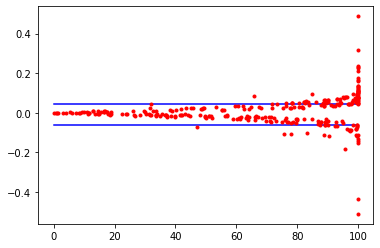

In [7]:
x = [0, 100]
pos_threshold = get_positive_threshold(y, 99)
neg_threshold = get_negative_threshold(y, 99)
y1 = [pos_threshold, pos_threshold]
y2 = [neg_threshold, neg_threshold]
plt.plot(x, y1, 'b')
plt.plot(x, y2, 'b')
plt.plot(y[:, 1], y[:, 0], 'r.')
plt.show()